In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# # Data preprocessing for hand data
# # root_dir = '/Users/mariaclarelusardi/1 Projects/Classes/ECE 598/HandClapRobot/processed_data'
# root_dir = './data/processed_data'   # Adjust as needed
# pattern = re.compile(r".*_hand_joints_.*.csv$")
# test_percent = 0.25         # May tune depending on amount of data

# joint_data = []                 # 75 features per hand, xyz coordinates for palm, 4 thumb joints, and 5 joints for index, middle, ring, and little finger each
# classifier_labels = []          # this is for training the classifier, contains ground truth gesture names for each sample
# label_to_int = {}               # maps string gesture names to numbers
# j = 0                           # Counter variable for assigning gesture names to numbers
# end_pose_labels = []            # this is for training the end pose predictor, contains the end position of the hands 

# gesture_classes = os.listdir(root_dir)              # Assumed directory contains a folder for each gesture
# # gesture_classes = ['front_five']  # For testing until I get all the data
# longest_samp = 0                  # Store length of longest sample we find for padding purposes

# for gesture in gesture_classes:
#     if gesture not in label_to_int:
#             label_to_int[gesture] = j
#             j += 1
#     gesture_dir = os.path.join(root_dir, gesture)
#     recordings = sorted(os.listdir(gesture_dir))      # Sorting makes debugging easier
#     for rec in recordings:
#         rec_dir = os.path.join(gesture_dir, rec) 
#         total_sample = []
#         end_pose = []
        
#         files = sorted([f for f in os.listdir(rec_dir) if pattern.search(f)])  # guarantee alphabetical order (left hand before right)
#         for filename in files:                                                 # Should loop twice per recording, one for right and one for left hand
#             hand_joints = pd.read_csv(rec_dir + f'/{filename}')
#             hand_joints = hand_joints.drop(['stamp_sec', 'stamp_nanosec', 'Wrist_x', 'Wrist_y', 'Wrist_z'], axis=1)
#             end_pose.append(hand_joints[['Palm_x', 'Palm_y', 'Palm_z']].iloc[-1].values)        # Robot end effector is tracking the palm joint
#             total_sample.append(torch.from_numpy(hand_joints.values).to(dtype=torch.float32))
            
#         total_sample = torch.cat(total_sample, axis=1)          # Concatenating left and right hand data
#         if total_sample.shape[0] > longest_samp:
#             longest_samp = total_sample.shape[0]
#         joint_data.append(total_sample)
#         classifier_labels.append(label_to_int[gesture])                     # Appending the assigned number to the label
#         end_pose_labels.append(torch.tensor(np.concatenate(end_pose), dtype=torch.float32))

# # Weird thing that nn.functional.pad requires a dummy 'channel' dimension that it doesn't even use, hence adding None here and then removing it
# joint_data = [F.pad(t[None, :, :], (0, 0, 0, longest_samp - t.shape[0]), mode='replicate').squeeze(0) for t in joint_data]        

# joint_gesture_data = [torch.cat((j, torch.tensor(l).expand(longest_samp,1)), dim=1) for j, l in zip(joint_data, classifier_labels)]

# ############## Train/Test data for the gesture classifier model ##########################
# X_train_gestures, X_test_gestures, y_train_gestures, y_test_gestures = \
#     train_test_split(joint_data, classifier_labels, test_size=test_percent, random_state=42, shuffle=True)

# X_train_gestures = torch.stack(X_train_gestures)
# y_train_gestures = torch.tensor(y_train_gestures)
# train_gesture_dataset = TensorDataset(X_train_gestures, y_train_gestures)
# train_gesture_loader = DataLoader(train_gesture_dataset, batch_size=None, shuffle=True)

# X_test_gestures = torch.stack(X_test_gestures)
# y_test_gestures = torch.tensor(y_test_gestures)
# test_gesture_dataset = TensorDataset(X_test_gestures, y_test_gestures)
# test_gesture_loader = DataLoader(test_gesture_dataset, batch_size=None)

# ############## Train/Test data for the end_pose model ##########################
# X_train_pose, X_test_pose, y_train_pose, y_test_pose = \
#     train_test_split(joint_gesture_data, end_pose_labels, test_size=test_percent, random_state=42, shuffle=True)

# X_train_pose = torch.stack(X_train_pose)
# y_train_pose = torch.stack(y_train_pose)
# train_pose_dataset = TensorDataset(X_train_pose, y_train_pose)
# train_pose_loader = DataLoader(train_pose_dataset, batch_size=None, shuffle=True)

# X_test_pose = torch.stack(X_test_pose)
# y_test_pose = torch.stack(y_test_pose)
# test_pose_dataset = TensorDataset(X_test_pose, y_test_pose)
# test_pose_loader = DataLoader(test_pose_dataset, batch_size=None)


In [3]:
# Data preprocessing for hand data
# root_dir = '/Users/mariaclarelusardi/1 Projects/Classes/ECE 598/HandClapRobot/processed_data'
root_dir = './data/new_data'   # Adjust as needed
pattern = re.compile(r".*_hand_joints_.*.csv$")
test_percent = 0.25         # May tune depending on amount of data

joint_data = []                 # 75 features per hand, xyz coordinates for palm, 4 thumb joints, and 5 joints for index, middle, ring, and little finger each
classifier_labels = []          # this is for training the classifier, contains ground truth gesture names for each sample
label_to_int = {}               # maps string gesture names to numbers
gesture_counter = 0             # Counter variable for assigning gesture names to numbers
end_pose_labels = []            # this is for training the end pose predictor, contains the end position of the hands 

gesture_classes = os.listdir(root_dir)              # Assumed directory contains a folder for each gesture
# gesture_classes = ['front_five']  # For testing until I get all the data
longest_samp = 0                  # Store length of longest sample we find for padding purposes

for gesture in gesture_classes:
    if gesture not in label_to_int:
            label_to_int[gesture] = gesture_counter
            gesture_counter += 1
    gesture_dir = os.path.join(root_dir, gesture)
    recordings = sorted(os.listdir(gesture_dir))      # Sorting makes debugging easier
    for rec in recordings:
        rec_dir = os.path.join(gesture_dir, rec)
        total_sample = []
        end_pose = []

        files = sorted([f for f in os.listdir(rec_dir) if pattern.search(f)])  # guarantee alphabetical order (left hand before right)
        for filename in files:                                                 # Should loop twice per recording, one for right and one for left hand
            hand_joints = pd.read_csv(rec_dir + f'/{filename}')
            hand_joints = hand_joints.drop(['stamp_sec', 'stamp_nanosec', 'Wrist_x', 'Wrist_y', 'Wrist_z'], axis=1)
            end_pose.append(hand_joints[['Palm_x', 'Palm_y', 'Palm_z']].iloc[-1].values)        # Robot end effector is tracking the palm joint
            # total_sample.append(torch.from_numpy(hand_joints.values).to(dtype=torch.float32))
            data = np.zeros_like(hand_joints.values)

            for idx in range(1, hand_joints.values.shape[0]-1):
                data[idx, :] = hand_joints.values[idx] - hand_joints.values[idx-1]

            total_sample.append(torch.from_numpy(data).to(dtype=torch.float32))


        total_sample = torch.cat(total_sample, axis=1)          # Concatenating left and right hand data
        if total_sample.shape[0] > longest_samp:
            longest_samp = total_sample.shape[0]
        joint_data.append(total_sample)
        classifier_labels.append(label_to_int[gesture])                     # Appending the assigned number to the label
        end_pose_labels.append(torch.tensor(np.concatenate(end_pose), dtype=torch.float32))

# Weird thing that nn.functional.pad requires a dummy 'channel' dimension that it doesn't even use, hence adding None here and then removing it
joint_data = [F.pad(t[None, :, :], (0, 0, 0, longest_samp - t.shape[0]), mode='replicate').squeeze(0) for t in joint_data]        
joint_gesture_data = [torch.cat((j, torch.tensor(l).expand(longest_samp,1)), dim=1) for j, l in zip(joint_data, classifier_labels)]

############## Train/Test data for the gesture classifier model ##########################
X_train_gestures, X_test_gestures, y_train_gestures, y_test_gestures = \
    train_test_split(joint_data, classifier_labels, test_size=test_percent, random_state=42, shuffle=True)

X_train_gestures = torch.stack(X_train_gestures)
y_train_gestures = torch.tensor(y_train_gestures)
train_gesture_dataset = TensorDataset(X_train_gestures, y_train_gestures)
train_gesture_loader = DataLoader(train_gesture_dataset, batch_size=None, shuffle=True)

X_test_gestures = torch.stack(X_test_gestures)
y_test_gestures = torch.tensor(y_test_gestures)
test_gesture_dataset = TensorDataset(X_test_gestures, y_test_gestures)
test_gesture_loader = DataLoader(test_gesture_dataset, batch_size=None)

############## Train/Test data for the end_pose model ##########################
X_train_pose, X_test_pose, y_train_pose, y_test_pose = \
    train_test_split(joint_gesture_data, end_pose_labels, test_size=test_percent, random_state=42, shuffle=True)

X_train_pose = torch.stack(X_train_pose)
y_train_pose = torch.stack(y_train_pose)
train_pose_dataset = TensorDataset(X_train_pose, y_train_pose)
train_pose_loader = DataLoader(train_pose_dataset, batch_size=None, shuffle=True)

X_test_pose = torch.stack(X_test_pose)
y_test_pose = torch.stack(y_test_pose)
test_pose_dataset = TensorDataset(X_test_pose, y_test_pose)
test_pose_loader = DataLoader(test_pose_dataset, batch_size=None)


In [4]:
# Some sanity checks

print(len(joint_data))
print(len(classifier_labels))
print(len(joint_gesture_data))
print(len(end_pose_labels))

print(joint_data[0].shape)
print(joint_gesture_data[0].shape)
print(longest_samp)

print(classifier_labels[79])

for i, (inputs, label) in enumerate(train_gesture_loader):
    print(inputs.shape)
    break


138
138
138
138
torch.Size([24, 150])
torch.Size([24, 151])
24
2
torch.Size([24, 150])


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()                                           # initialize the superclass from nn.Module for LSTM
        self.hidden_dim = hidden_dim                                                # How many nodes are in each hidden layer?
        self.layer_dim = layer_dim                                                  # How many hidden layers are there?
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim)                       # Also giving number of features in input
        self.fc = nn.Linear(hidden_dim, output_dim)                                 # Fully connected layer for giving output, needs to know output dimensions

    def forward(self, x, h0=None, c0=None):
        # h0 is hidden state (aka short term memory)
        # c0 is cell state (aka long term memory)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, hn, cn
    
class LSTMModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel2, self).__init__()                                           # initialize the superclass from nn.Module for LSTM
        self.hidden_dim = hidden_dim                                                # How many nodes are in each hidden layer?
        self.layer_dim = layer_dim                                                  # How many hidden layers are there?
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim)                       # Also giving number of features in input
        self.relu = nn.ReLU()                                                       # ReLU activation function
        self.dropout = nn.Dropout(p=0.3)                                            # Dropout layer for regularization  
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)                            # Intermediate fully connected layer
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)                                 # Final fully connected layer for giving output, needs to know output dimensions
        self.fc = nn.Linear(hidden_dim // 4, output_dim)                                 # Fully connected layer for giving output, needs to know output dimensions

    def forward(self, x, h0=None, c0=None):
        # h0 is hidden state (aka short term memory)
        # c0 is cell state (aka long term memory)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hn, cn

In [16]:
# Training model for gesture classification

# Hyperparams
input_dim = 150
output_dim = 5
hidden_dim = 256
layer_dim = 1
num_epochs = 1000
# gesture_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim)
gesture_model = LSTMModel2(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim)

gesture_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gesture_model.parameters(), lr=0.01)       # Adaptive moment estimation (Adam) for automatically adjusting the learning rate

In [17]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
h0, c0 = None, None
train_losses = []

for epoch in range(num_epochs):
    gesture_model.train()
    running_loss = 0.0
    
    for i, (inputs, label) in enumerate(train_gesture_loader):
        inputs, label = inputs.to(device), label.to(device)
        optimizer.zero_grad()
        outputs, h0, c0 = gesture_model(inputs, h0, c0)
        loss = gesture_criterion(outputs, label.expand(longest_samp))           # Comparing model outputs with ground truth
        loss.backward()                                       # Backpropagation
        optimizer.step()                                      # Optimize all weights and biases
        running_loss += loss.item()

        h0, c0 = h0.detach(), c0.detach()                     # Get new long and short term memory variables (detached from their gradients)

    train_loss = running_loss / len(train_gesture_loader)
    train_losses.append(train_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 1.4233
Epoch [20/1000], Loss: 1.5731
Epoch [30/1000], Loss: 1.4377
Epoch [40/1000], Loss: 1.5599
Epoch [50/1000], Loss: 1.4323
Epoch [60/1000], Loss: 1.5718
Epoch [70/1000], Loss: 1.7523
Epoch [80/1000], Loss: 2.0070
Epoch [90/1000], Loss: 1.6733
Epoch [100/1000], Loss: 1.5578
Epoch [110/1000], Loss: 1.4343


KeyboardInterrupt: 

Text(0.5, 1.0, 'Train Loss')

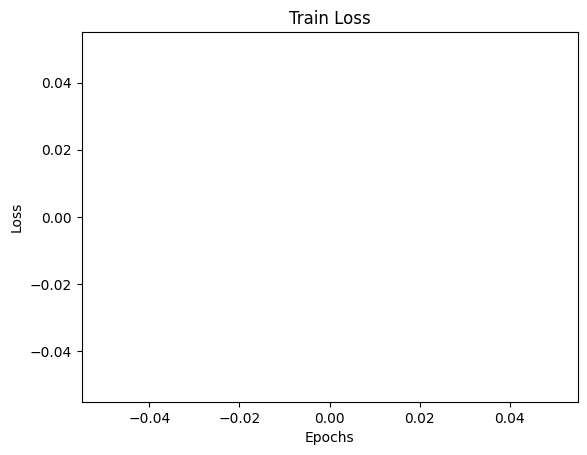

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')

In [ ]:
test_loss = 0.0
correct_test = 0
total_test = 0

gesture_model.eval()
print(X_test_gestures.shape)

with torch.no_grad():
    for i, (inputs, label) in enumerate(test_gesture_loader):
        inputs, label = inputs.to(device), label.to(device)
        outputs, _, _ = gesture_model(inputs, h0, c0)
        # outputs, _, _ = gesture_model(inputs)
        loss = gesture_criterion(outputs, label.expand(longest_samp))
        test_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)           # prediction is the 1 class with the highest probability
        correct_test += (predicted == label.expand(longest_samp)).sum().item()
        total_test += longest_samp


test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss/len(test_gesture_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')



torch.Size([20, 21, 150])
Test Loss: 2.4029, Test Accuracy: 87.38%


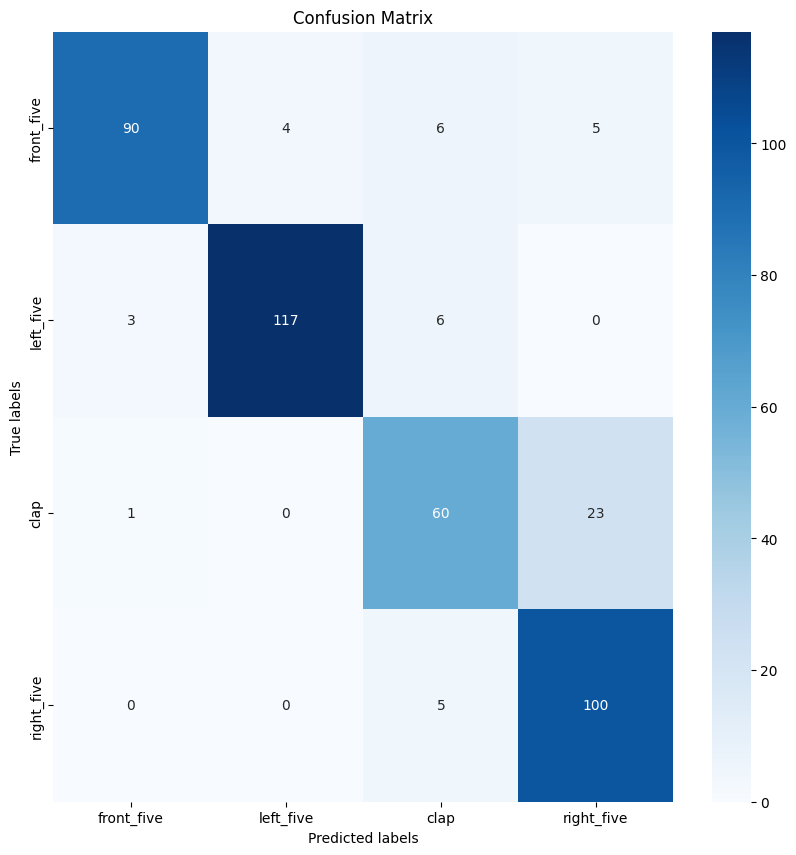

dict_keys(['front_five', 'left_five', 'clap', 'right_five'])


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the model's predictions
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            labels = labels.expand(longest_samp)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _, _ = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

predictions, true_labels = get_predictions(gesture_model, test_gesture_loader)

# Generate confusion matrix - based on all data in test
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=True,
            xticklabels=list(label_to_int.keys()),
            yticklabels=list(label_to_int.keys()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(label_to_int.keys())

torch.save(gesture_model.state_dict(), 'gesture_lstm_model.pth')

In [ ]:
# Training model for end pose prediction

# Hyperparams
input_dim = 151
output_dim = 6
hidden_dim = 100
layer_dim = 1
num_epochs = 3000

pose_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim)
pose_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gesture_model.parameters(), lr=0.01) 

In [ ]:

h0, c0 = None, None

for epoch in range(num_epochs):
    pose_model.train()
    
    for i, (inputs, label) in enumerate(train_pose_loader):
        inputs, label = inputs.to(device), label.to(device)
        optimizer.zero_grad()
        outputs, h0, c0 = pose_model(inputs, h0, c0)
        loss = pose_criterion(outputs, label.expand(longest_samp, output_dim))           # Comparing model outputs with ground truth
        loss.backward()                                       # Backpropagation
        optimizer.step()                                      # Optimize all weights and biases
        h0, c0 = h0.detach(), c0.detach()                     # Get new long and short term memory variables (detached from their gradients)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/3000], Loss: 0.5930
Epoch [20/3000], Loss: 0.5729
Epoch [30/3000], Loss: 0.5779
Epoch [40/3000], Loss: 0.6048
Epoch [50/3000], Loss: 0.5937
Epoch [60/3000], Loss: 0.5796
Epoch [70/3000], Loss: 0.5917
Epoch [80/3000], Loss: 0.6318
Epoch [90/3000], Loss: 0.5812
Epoch [100/3000], Loss: 0.5747
Epoch [110/3000], Loss: 0.6152
Epoch [120/3000], Loss: 0.5905
Epoch [130/3000], Loss: 0.5779
Epoch [140/3000], Loss: 0.5781
Epoch [150/3000], Loss: 0.5927
Epoch [160/3000], Loss: 0.6048
Epoch [170/3000], Loss: 0.5986
Epoch [180/3000], Loss: 0.5692
Epoch [190/3000], Loss: 0.5780
Epoch [200/3000], Loss: 0.5812
Epoch [210/3000], Loss: 0.6140
Epoch [220/3000], Loss: 0.5779


KeyboardInterrupt: 

In [ ]:
test_loss = 0.0
correct_test = 0
total_test = 0

pose_model.eval()
print(X_test_pose.shape)

with torch.no_grad():
    for i, (inputs, label) in enumerate(test_pose_loader):
        inputs, label = inputs.to(device), label.to(device)
        outputs, _, _ = pose_model(inputs, h0, c0)
        loss = pose_criterion(outputs, label.expand(longest_samp, output_dim))
        test_loss += loss.item()
        print(predicted.shape)


test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss/len(test_gesture_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

torch.Size([20, 21, 151])
torch.Size([21])


RuntimeError: The size of tensor a (21) must match the size of tensor b (6) at non-singleton dimension 1

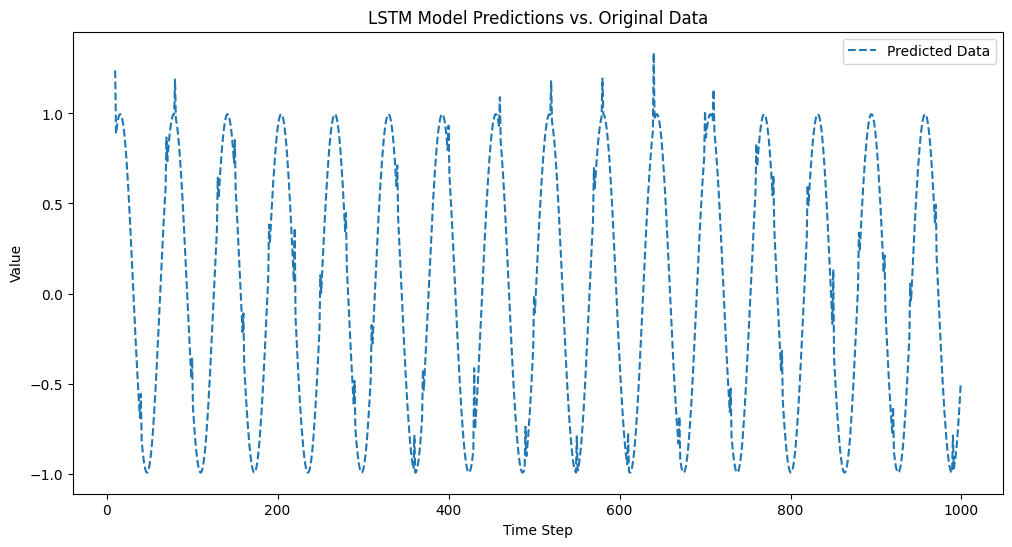

In [ ]:
# Example eval from tutorial - may be suitable for ploting pose error
# gesture_model.eval()
# predicted, _, _ = model(trainX, h0, c0)

# original = data[seq_length:]                    # Don't start predicting until seq_length steps out
# time_steps = np.arange(seq_length, len(data))   # Our x values for time steps starting at seq_length and going to the end of the data

# predicted[::30] += 0.2
# predicted[::70] += 0.2

# plt.figure(figsize=(12, 6))
# # plt.plot(time_steps, original, label='Original Data')
# plt.plot(time_steps, predicted.detach().numpy(),
#          label='Predicted Data', linestyle='--')
# plt.title('LSTM Model Predictions vs. Original Data')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.legend()
# plt.show()